In [1]:
# pip install fuzzywuzzy
# pip install unicodedata2
# pip install soccerplots


# TODO: CLEAN CODE AND ENSURE CLEAN RUN THROUGH

In [1]:
# %matplotlib inline


import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.style as style
import matplotlib as mpl
import matplotlib.patheffects as pe
import warnings
import requests
import os
import numpy as np
from math import pi
from bs4 import BeautifulSoup
from urllib.request import urlopen
from highlight_text import fig_text
from adjustText import adjust_text
from soccerplots.radar_chart import Radar
from mplsoccer import PyPizza, add_image, FontManager

style.use('fivethirtyeight')

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=97, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1
    
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii = str(only_ascii)
    only_ascii = only_ascii[2:-1]
    only_ascii = only_ascii.replace('-', ' ')
    return only_ascii


def years_converter(variable_value):
    if len(variable_value) > 3:
        years = variable_value[:-4]
        days = variable_value[3:]
        years_value = pd.to_numeric(years)
        days_value = pd.to_numeric(days)
        day_conv = days_value/365
        final_val = years_value + day_conv
    else:
        final_val = pd.to_numeric(variable_value)

    return final_val



In [3]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database


In [4]:
team_urls = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
full_urls = list(team_urls.urls.unique())

In [5]:
import time 

keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
defensive_mids = ['MF,DF']
midfielders = ['MF']
attacking_mids = ['MF,FW',"FW,MF"]
forwards = ['FW']
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

def general_url_database(full_urls):    
    appended_data = []
    for team_url in full_urls:
        # url = team_url
        print(team_url)
        player_db = pd.DataFrame()
        player_urls = []
        # data  = requests.get(team_url).text
        links = BeautifulSoup(requests.get(team_url).text).select('th a')
        urls = [link['href'] for link in links]
        player_urls.append(urls)
        player_urls  = [item for sublist in player_urls  for item in sublist]
        player_urls.sort()
        player_urls = list(set(player_urls))
        p_url = list(filter(lambda k: 'players' in k, player_urls))
        url_final = []
        for y in p_url:
            full_url = "https://fbref.com"+y
            url_final.append(full_url)
        player_names = []
        for player in p_url: 
            player_name_slice = player[21:]
            player_name_slice = player_name_slice.replace('-', ' ')
            player_names.append(player_name_slice)
        # player_names
        list_of_tuples = list(zip(player_names, url_final))
        play_url_database = pd.DataFrame(list_of_tuples, columns = ['Player', 'urls'])
        player_db = pd.concat([play_url_database])

        # # html = requests.get(url).text
        # data2 = BeautifulSoup(requests.get(url).text, 'html5')
        table = BeautifulSoup(requests.get(team_url).text, 'html5').find('table')
        cols = []

        for header in table.find_all('th'):
            cols.append(header.string)

        cols = [i for i in cols if i is not None]

        columns = cols[6:39] #gets necessary column headers
        players = cols[39:-2]

        rows = [] #initliaze list to store all rows of data
        for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
            if len(row.find_all('td')) > 0: 
                rowdata = [] #initiliaze list of row data
                for i in range(0,len(row.find_all('td'))): #get all column values for row
                    rowdata.append(row.find_all('td')[i].text)
                rows.append(rowdata)
        df = pd.DataFrame(rows, columns=columns)

        df.drop(df.tail(2).index,inplace=True)
        df["Player"] = players
        df = df[["Player","Pos","Age", "Starts"]]

        df['Player'] = df.apply(lambda x: remove_accents(x['Player']), axis=1)
        test_merge = fuzzy_merge(df, player_db, 'Player', 'Player', threshold=90)
        test_merge = test_merge.rename(columns={'matches': 'Player', 'Player': 'matches'})
        # test_merge = test_merge.drop(columns=['matches'])
        final_merge = test_merge.merge(player_db, on='Player', how='left')
        del df, table
        time.sleep(10)
        # list_of_dfs.append(final_merge)
        appended_data.append(final_merge)
    appended_data = pd.concat(appended_data)
    return appended_data 
def get_360_scouting_report(url):    
    start = url[0:38]+ "scout/365_m1/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Scouting-Report"    
    return final_string
    
def get_match_logs(url):    
    start = url[0:38]+ "matchlogs/2024-2025/summary/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Match-Logs"   
    return final_string

def create_EPL_play_db(full_urls):
    df = general_url_database(full_urls)
    df['Age'] = df.apply(lambda x: years_converter(x['Age']), axis=1)
    df = df.drop(columns=['matches'])
    df['scouting_url'] = df.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)
    df['match_logs'] = df.apply(lambda x: get_match_logs(x['urls']), axis=1)
    df["position_group"] = df.Pos.apply(lambda x: position_grouping(x))
    df.reset_index(drop=True)
    df[["Starts"]] = df[["Starts"]].apply(pd.to_numeric)  
    return df

In [6]:
EPL_Player_db = create_EPL_play_db(full_urls)

# EPL_Player_db.to_csv('CSVs/EPL_Player_Database.csv')

https://fbref.com/en/squads/47c64c55/Crystal-Palace-Stats
https://fbref.com/en/squads/e4a775cb/Nottingham-Forest-Stats
https://fbref.com/en/squads/4ba7cbea/Bournemouth-Stats
https://fbref.com/en/squads/8602292d/Aston-Villa-Stats
https://fbref.com/en/squads/33c895d4/Southampton-Stats
https://fbref.com/en/squads/19538871/Manchester-United-Stats
https://fbref.com/en/squads/d3fd31cc/Everton-Stats
https://fbref.com/en/squads/b2b47a98/Newcastle-United-Stats
https://fbref.com/en/squads/cff3d9bb/Chelsea-Stats
https://fbref.com/en/squads/b74092de/Ipswich-Town-Stats
https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats
https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats
https://fbref.com/en/squads/a2d435b3/Leicester-City-Stats
https://fbref.com/en/squads/822bd0ba/Liverpool-Stats
https://fbref.com/en/squads/18bb7c10/Arsenal-Stats
https://fbref.com/en/squads/8cec06e1/Wolverhampton-Wanderers-Stats
https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats
https://fbref.com/en

In [19]:
EPL_Player_db = pd.read_csv('CSVs/EU_TOP_6L_Database.csv')

In [7]:
position = 'Central Midfielders'
pl_starts = 10
max_age = 26

subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )
players_needed = list(subset_of_data.urls.unique())

In [8]:
def get_player_multi_data(url_list:list):
    appended_data = []
    for url in url_list:
        warnings.filterwarnings("ignore")
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        metric_names = []
        metric_values = []
        remove_content = ["'", "[", "]", ","]
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('th')[0].contents
            metric_names.append(first_column)
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('td')[0].contents
            metric_values.append(first_column)

        metric_names = [item for sublist in metric_names for item in sublist]
        metric_values = [item for sublist in metric_values for item in sublist]

        df_player = pd.DataFrame()
        df_player['Name'] = name[0]
        for item in metric_names:
            df_player[item] = []

        name = name
        non_penalty_goals = (metric_values[0])
        npx_g = metric_values[1]
        shots_total = metric_values[2]
        assists = metric_values[3]
        x_a = metric_values[4]
        npx_g_plus_x_a = metric_values[5] 
        shot_creating_actions = metric_values[6] 
        passes_attempted = metric_values[7] 
        pass_completion_percent = metric_values[8] 
        progressive_passes = metric_values[9] 
        progressive_carries = metric_values[10] 
        successful_take_ons = metric_values[11] 
        touches_att_pen = metric_values[12]
        progressive_passes_rec = metric_values[13] 
        tackles = metric_values[14] 
        interceptions = metric_values[15] 
        blocks = metric_values[16]
        clearances = metric_values[17]
        aerials_won = metric_values[18]
        df_player.loc[0] = [name, non_penalty_goals, npx_g, shots_total, assists, x_a, npx_g_plus_x_a, shot_creating_actions, passes_attempted, pass_completion_percent,
                            progressive_passes, progressive_carries, successful_take_ons, touches_att_pen, progressive_passes_rec, tackles, interceptions, blocks,
                            clearances, aerials_won]
        appended_data.append(df_player)
    appended_data = pd.concat(appended_data)
    return appended_data

In [9]:
df = get_player_multi_data(players_needed)

In [ ]:
# def metrics_scatter_comparison(df, max_age, position):
        
#         df[['Progressive Passes', 'Progressive Carries','Passes Attempted']] =  df[['Progressive Passes','Progressive Carries','Passes Attempted']].apply(pd.to_numeric)         
#         df["Progressive_Actions_p90"] = df['Progressive Passes'] + df['Progressive Carries']
#         df["Passes_Attempted"] = df['Passes Attempted']

#         line_color = "silver"

#         # with cbook.get_sample_data('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/logo_transparent_background.png') as file:
#         #         im = image.imread(file)

#         style.use('fivethirtyeight')
#         fig, ax = plt.subplots(figsize=(12, 8)) 
#         ax.scatter(df["Progressive_Actions_p90"], df["Passes_Attempted"],alpha=0.8,marker="1") ##scatter points
#         ax.axvspan(10.0, 14.0, ymin=0.5, ymax=1, alpha=0.1, color='green',label= "In Form")

#         texts = [] ##plot player names
#         for row in df.itertuples():
#                 texts.append(ax.text(row.Progressive_Actions_p90, row.Passes_Attempted, row.Name, fontsize=8, ha='center', va='center', zorder=10))
#                 adjust_text(texts,force_text=(2, 2),
#             arrowprops=dict(arrowstyle='-',color='red'),
#             autoalign='y',
#             only_move={'points':'y','text':'y'})  ## to remove overlaps between labels

#         ## update plot
#                 ax.set(xlabel="Progressive Actions per 90", ylabel="Passes Attempted per 90", ylim=((df["Passes_Attempted"].min()-2), (df["Passes_Attempted"].max()+2)), xlim=((df["Progressive_Actions_p90"].min()-2), (df["Progressive_Actions_p90"].max()+2))) ## set labels and limits

#         ##grids and spines
#         ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
#         for spine in ["top", "right"]:
#                 ax.spines[spine].set_visible(False)
#                 ax.spines[spine].set_color(line_color)

#         ax.xaxis.label.set(fontsize=12, fontweight='bold')
#         ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

#         ax.set_position([0.05, 0.05, 0.82, 0.78]) ## make space for the title on top of the axes

#         ## title and subtitle
#         fig.text(x=0.08, y=0.92, s=f"U-{max_age} {position} | Progressive Actions Profile", 
#                  ha='left', fontsize=20, fontweight='book') 
#         fig.text(x=0.08, y=0.88, s=f"EPL | 2021-22", ha='left', 
#                 fontsize=16, fontweight='book')
        
#         # fig.figimage(im, 10, 10, zorder=3, alpha=.5,resize=True)

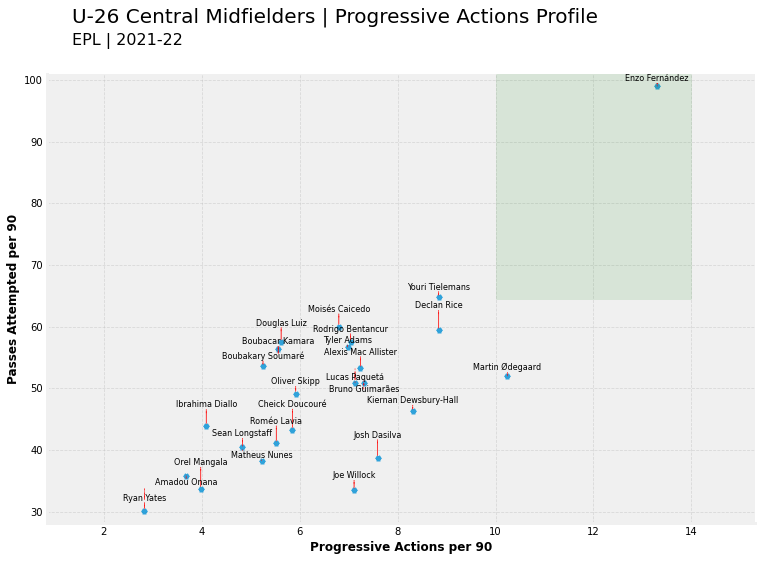

In [ ]:
# metrics_scatter_comparison(df, max_age, position)

In [15]:
EPL_Player_db

,Pos,Age,Starts,Player,urls,scouting_url,match_logs,position_group
0,DF,24.347945,11,Marc Guehi,https://fbref.com/en/players/d0706b27/Marc-Guehi,https://fbref.com/en/players/d0706b27/scout/36...,https://fbref.com/en/players/d0706b27/matchlog...,Defender
1,GK,27.684932,11,Dean Henderson,https://fbref.com/en/players/e5a76dfe/Dean-Hen...,https://fbref.com/en/players/e5a76dfe/scout/36...,https://fbref.com/en/players/e5a76dfe/matchlog...,GK
2,"DF,MF",25.210959,11,Tyrick Mitchell,https://fbref.com/en/players/5cbd1eb0/Tyrick-M...,https://fbref.com/en/players/5cbd1eb0/scout/36...,https://fbref.com/en/players/5cbd1eb0/matchlog...,Defender
3,"DF,MF",28.479452,11,Daniel Munoz,https://fbref.com/en/players/778ef829/Daniel-M...,https://fbref.com/en/players/778ef829/scout/36...,https://fbref.com/en/players/778ef829/matchlog...,Defender
4,"MF,FW",26.386301,9,Eberechi Eze,https://fbref.com/en/players/ae4fc6a4/Eberechi...,https://fbref.com/en/players/ae4fc6a4/scout/36...,https://fbref.com/en/players/ae4fc6a4/matchlog...,Attacking Midfielders
...,...,...,...,...,...,...,...,...
21,MF,23.528767,0,Edmond Paris Maghoma,https://fbref.com/en/players/8a3ddcd2/Edmond-P...,https://fbref.com/en/players/8a3ddcd2/scout/36...,https://fbref.com/en/players/8a3ddcd2/matchlog...,Central Midfielders
22,DF,18.389041,0,Jayden Meghoma,https://fbref.com/en/players/07382f6c/Jayden-M...,https://fbref.com/en/players/07382f6c/scout/36...,https://fbref.com/en/players/07382f6c/matchlog...,Defender
23,MF,22.164384,0,Myles Peart Harris,https://fbref.com/en/players/ea1a5662/Myles-Pe...,https://fbref.com/en/players/ea1a5662/scout/36...,https://fbref.com/en/players/ea1a5662/matchlog...,Central Midfielders
24,GK,23.095890,0,Hakon Rafn Valdimarsson,https://fbref.com/en/players/57a34cf4/Hakon-Ra...,https://fbref.com/en/players/57a34cf4/scout/36...,https://fbref.com/en/players/57a34cf4/matchlog...,GK


In [46]:
position = 'Attacking Midfielders'
pl_starts = 7

subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts')
players_needed = list(subset_of_data.match_logs.unique())



In [47]:
players_needed

['https://fbref.com/en/players/ae4fc6a4/matchlogs/2024-2025/summary/Eberechi-Eze-Match-Logs',
 'https://fbref.com/en/players/de31038e/matchlogs/2024-2025/summary/Elliot-Anderson-Match-Logs',
 'https://fbref.com/en/players/5c0da4a4/matchlogs/2024-2025/summary/Marcus-Tavernier-Match-Logs',
 'https://fbref.com/en/players/4c3a6744/matchlogs/2024-2025/summary/Justin-Kluivert-Match-Logs',
 'https://fbref.com/en/players/2e5915f1/matchlogs/2024-2025/summary/Morgan-Rogers-Match-Logs',
 'https://fbref.com/en/players/507c7bdf/matchlogs/2024-2025/summary/Bruno-Fernandes-Match-Logs',
 'https://fbref.com/en/players/fc15fb84/matchlogs/2024-2025/summary/Dwight-McNeil-Match-Logs',
 'https://fbref.com/en/players/c17bfb65/matchlogs/2024-2025/summary/Joelinton-Match-Logs',
 'https://fbref.com/en/players/dc7f8a28/matchlogs/2024-2025/summary/Cole-Palmer-Match-Logs',
 'https://fbref.com/en/players/bd9553e6/matchlogs/2024-2025/summary/Omari-Hutchinson-Match-Logs',
 'https://fbref.com/en/players/3eb22ec9/match

In [48]:
import time
def league_performance_df(match_links):
    data_append = []
    for x in match_links:
        print(x)
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
        df = pd.read_html(html_content)
        df[0].columns = df[0].columns.droplevel(0) # drop top header row
        stats = df[0]
        stats = stats[(stats.Comp == "Premier League") & (stats.Pos != "On matchday squad, but did not play")]
        season = stats[['Date','Gls', 'Ast',  'xG', 'npxG', 'xAG', 'Squad']]
        columns_to_convert = ['Gls', 'Ast', 'xG', 'npxG', 'xAG']
        for col in columns_to_convert:
            season[col] = pd.to_numeric(season[col], errors='coerce').fillna(0).astype(float)
        season = season.rename({'Squad': 'team'}, axis=1)
        season['Player'] = name
        data_append.append(season)
        del df, soup
        time.sleep(10)
    df_total = pd.concat(data_append)

    return df_total



In [49]:
pergame_data = league_performance_df(players_needed)


https://fbref.com/en/players/ae4fc6a4/matchlogs/2024-2025/summary/Eberechi-Eze-Match-Logs


https://fbref.com/en/players/de31038e/matchlogs/2024-2025/summary/Elliot-Anderson-Match-Logs
https://fbref.com/en/players/5c0da4a4/matchlogs/2024-2025/summary/Marcus-Tavernier-Match-Logs
https://fbref.com/en/players/4c3a6744/matchlogs/2024-2025/summary/Justin-Kluivert-Match-Logs
https://fbref.com/en/players/2e5915f1/matchlogs/2024-2025/summary/Morgan-Rogers-Match-Logs
https://fbref.com/en/players/507c7bdf/matchlogs/2024-2025/summary/Bruno-Fernandes-Match-Logs
https://fbref.com/en/players/fc15fb84/matchlogs/2024-2025/summary/Dwight-McNeil-Match-Logs
https://fbref.com/en/players/c17bfb65/matchlogs/2024-2025/summary/Joelinton-Match-Logs
https://fbref.com/en/players/dc7f8a28/matchlogs/2024-2025/summary/Cole-Palmer-Match-Logs
https://fbref.com/en/players/bd9553e6/matchlogs/2024-2025/summary/Omari-Hutchinson-Match-Logs
https://fbref.com/en/players/3eb22ec9/matchlogs/2024-2025/summary/Bernardo-Silva-Match-Logs
https://fbref.com/en/players/74618572/matchlogs/2024-2025/summary/Kaoru-Mitoma-Matc

In [50]:
pergame_data.to_csv('pergamedata.csv')

In [57]:

df_top_10 = pergame_data.groupby(['Player','team']).sum().reset_index().assign(difference = lambda x: x.Ast-x.xAG )
df_top_10.sort_values(by='Gls',ascending=False)
df_top_10 = df_top_10.sort_values(by='Ast',ascending=False).head(20).reset_index(drop=True)
fm_ids = pd.read_csv("CSVs/Top6_leagues_fotmob_ids.csv")
fm_ids = fm_ids[["team", "team_id"]]
df_top_10 = df_top_10.merge(fm_ids, on='team', how='left')

In [58]:
df_top_10

,Player,team,Gls,Ast,xG,npxG,xAG,difference,team_id
0,Bukayo Saka,Arsenal,3.0,7.0,2.5,2.5,3.9,3.1,9825
1,Cole Palmer,Chelsea,7.0,5.0,5.2,4.4,4.8,0.2,8455
2,Adama Traoré,Fulham,1.0,3.0,2.8,2.8,2.4,0.6,9879
3,Bruno Fernandes,Manchester Utd,2.0,3.0,4.0,3.2,3.0,0.0,10260
4,Dwight McNeil,Everton,3.0,3.0,0.7,0.7,2.9,0.1,8668
5,Mikkel Damsgaard,Brentford,1.0,3.0,0.8,0.8,2.8,0.2,9937
6,Elliot Anderson,Nott'ham Forest,0.0,3.0,0.7,0.7,1.5,1.5,10203
7,Bernardo Silva,Manchester City,0.0,3.0,1.5,1.5,2.4,0.6,8456
8,Justin Kluivert,Bournemouth,2.0,2.0,2.0,1.2,1.1,0.9,8678
9,Morgan Rogers,Aston Villa,3.0,2.0,2.6,2.6,2.4,-0.4,10252


In [59]:
def get_cumulative(player, data = pergame_data):

    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df= df[(df['Player'] == player)][['Player', 'Ast', 'xAG', 'Date']].reset_index(drop=True)
  
    df.sort_values(by='Date', ascending=True).reset_index(drop=True)
    df['cum_assists'] = df['Ast'].cumsum()
    df['cum_xassists'] = df['xAG'].cumsum()
    return df

# Check to see if it works
get_cumulative('Mohamed Salah')

,Player,Ast,xAG,Date,cum_assists,cum_xassists


In [62]:
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

def plot_point_difference(ax, player, label_y = False, data=pergame_data):
    ax.grid(ls='--', color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
        spine.set_visible(False)
    ax.tick_params(color='lightgrey', labelsize=6, labelcolor='grey')
    test_df = get_cumulative(player, data)

    ax.plot(test_df.index + 1, test_df['cum_assists'], marker='o', mfc='white', ms=1,linewidth=1, color='#287271')
    ax.plot(test_df.index + 1, test_df['cum_xassists'], marker='o', mfc='white', ms=1, linewidth=1,color='#D81159')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylim(-1,30)
    ax.set_xlim(0.25)
    ax.set_xticklabels([])
    if len(test_df) > 0:
        difference = test_df['cum_assists'].iloc[-1] - test_df['cum_xassists'].iloc[-1]
        mid_point = test_df['cum_assists'].iloc[-1] + (test_df['cum_xassists'].iloc[-1] - test_df['cum_assists'].iloc[-1])/2

        text_ = ax.annotate(
            xy=(ax.get_xlim()[1], mid_point),
            text=f'{difference:.1f}',
            xytext=(-5,0),
            ha='center',
            va='center',
            color='#D81159',
            weight='bold',
            size=7,
            textcoords='offset points'
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
        )
    

    # ----------------------------------------------------------------
    if label_y:
        ax.set_ylabel('Assists', color='grey', size=8)
    else:
        ax.set_yticklabels([])

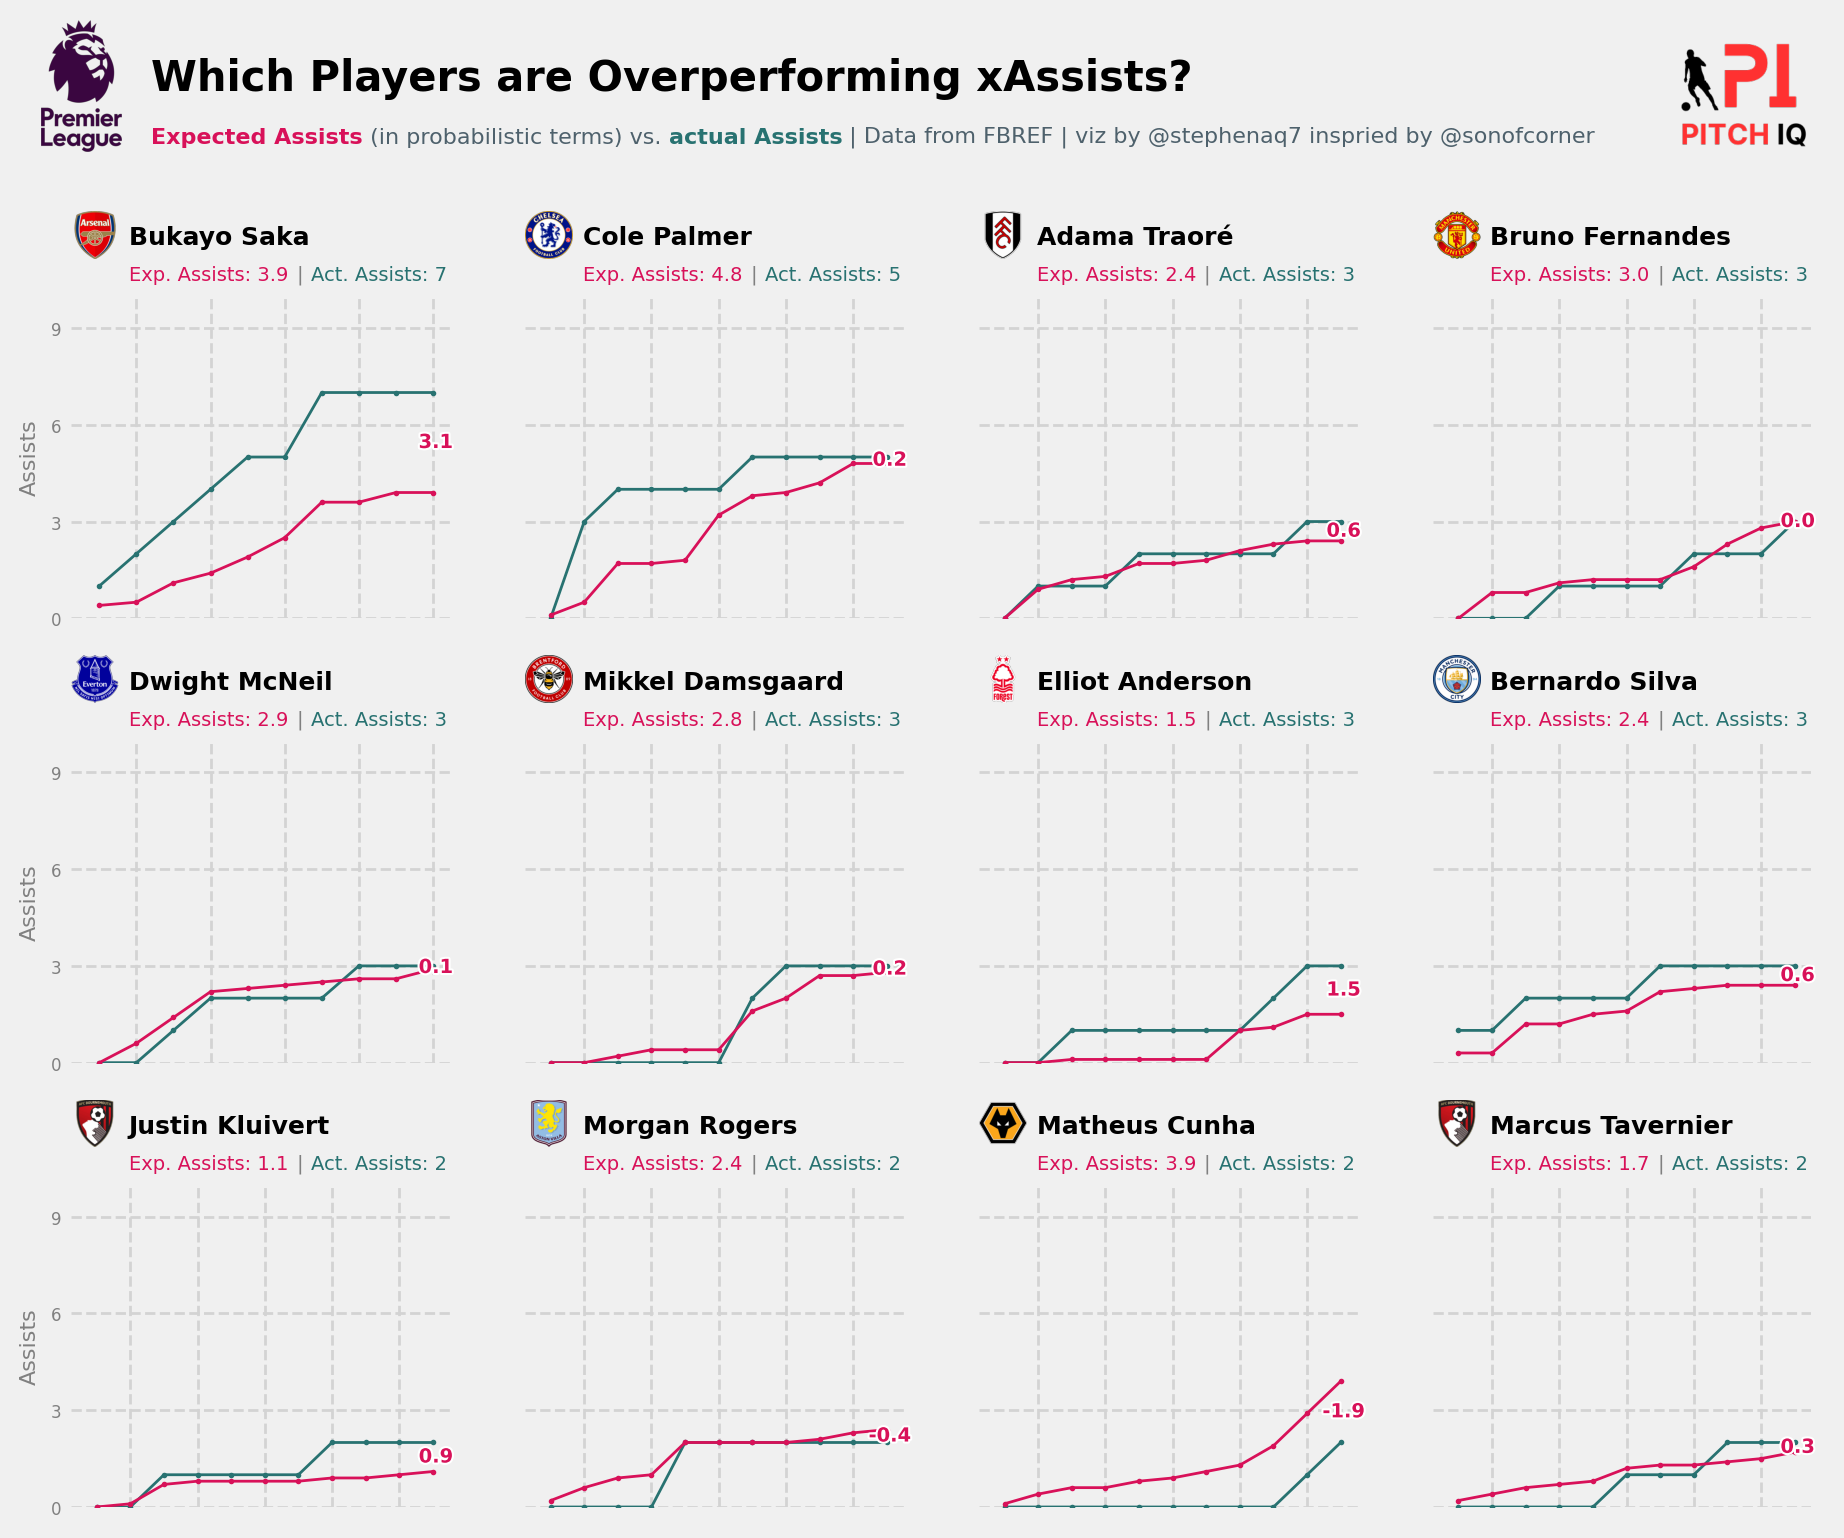

In [63]:
import matplotlib.gridspec as gridspec
from highlight_text import fig_text, ax_text
from PIL import Image
import urllib
style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 8), dpi = 200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], hspace=0.2
)
# plt.rcParams['figure.facecolor'] = '#EFE9E6'
plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                # facecolor = "#EFE9E6"
            )
            player = df_top_10['Player'].iloc[plot_counter]
            if col == 0:
                label_y = True
            else:
                label_y = False
            
            plot_point_difference(ax, player, label_y)
            ax.set_ylim(0, 10)            
            plot_counter += 1
        else:
            teamId = df_top_10['team_id'].iloc[logo_counter]
            PlayerName = df_top_10['Player'].iloc[logo_counter]
            xgoals = df_top_10['xAG'].iloc[logo_counter]
            agoals = df_top_10['Ast'].iloc[logo_counter]
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png'))
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # -- Add the team name
            ax_text(
                x = 1.2, 
                y = 0.7,
                s = f'<{PlayerName}>\n<Exp. Assists: {xgoals:.1f}> <|> <Act. Assists: {agoals:.0f}>',
                ax = logo_ax, 
                highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},{'size':'7', 'color': '#D81159'}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': '#287271'}],
                font = 'DM Sans', 
                ha = 'left', 
                size = 9, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.95, 
    s='Which Players are Overperforming xAssists?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
	x=0.12, y=.92, 
    s='<Expected Assists> (in probabilistic terms) vs. <actual Assists> | Data from FBREF | viz by @stephenaq7 inspried by @sonofcorner',
    highlight_textprops=[{'weight':'bold', 'color': '#D81159'}, {'weight':'bold', 'color': '#287271'}],
	va='bottom', ha='left',
	fontsize=8, color='#4E616C', font='DejaVu Sans.'
)



ax2 = fig.add_axes([0.065, 0.008, 0.04, 1.90])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.88, 0.89, 0.07, 0.13])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
ax3.imshow(img)

plt.savefig(
	"outputs/10032022_overperformers.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False)

In [68]:
positions = ['Attacking Midfielders', 'Forwards', 'Central Midfielders']  # List of positions
pl_starts = 7

subset_of_data = EPL_Player_db.query('position_group in @positions & Starts > @pl_starts')
players_needed = list(subset_of_data.match_logs.unique())

pergame_data = league_performance_df(players_needed)



https://fbref.com/en/players/ae4fc6a4/matchlogs/2024-2025/summary/Eberechi-Eze-Match-Logs
https://fbref.com/en/players/50e6dc35/matchlogs/2024-2025/summary/Jean-Philippe-Mateta-Match-Logs
https://fbref.com/en/players/4b542852/matchlogs/2024-2025/summary/Adam-Wharton-Match-Logs
https://fbref.com/en/players/4e9a0555/matchlogs/2024-2025/summary/Chris-Wood-Match-Logs
https://fbref.com/en/players/15f3ec41/matchlogs/2024-2025/summary/Callum-Hudson-Odoi-Match-Logs
https://fbref.com/en/players/2fba6108/matchlogs/2024-2025/summary/Anthony-Elanga-Match-Logs
https://fbref.com/en/players/de31038e/matchlogs/2024-2025/summary/Elliot-Anderson-Match-Logs
https://fbref.com/en/players/32f60ed8/matchlogs/2024-2025/summary/Morgan-Gibbs-White-Match-Logs
https://fbref.com/en/players/2afc7272/matchlogs/2024-2025/summary/Lewis-Cook-Match-Logs
https://fbref.com/en/players/efd2ec23/matchlogs/2024-2025/summary/Antoine-Semenyo-Match-Logs
https://fbref.com/en/players/5c0da4a4/matchlogs/2024-2025/summary/Marcus-Tav

In [71]:
df_top_10 = pergame_data.groupby(['Player','team']).sum().reset_index().assign(difference = lambda x: x.Ast-x.xAG )
df_top_10.sort_values(by='Gls',ascending=False)
fm_ids = pd.read_csv("CSVs/Top6_leagues_fotmob_ids.csv")
fm_ids = fm_ids[["team", "team_id"]]
df_top_10 = df_top_10.merge(fm_ids, on='team', how='left')
df_top_10 = df_top_10[df_top_10['team_id'] == 9825]


In [72]:
df_top_10

,Player,team,Gls,Ast,xG,npxG,xAG,difference,team_id
16,Bukayo Saka,Arsenal,3.0,7.0,2.5,2.5,3.9,3.1,9825
22,Declan Rice,Arsenal,0.0,1.0,0.7,0.7,1.5,-0.5,9825
35,Gabriel Martinelli,Arsenal,3.0,2.0,2.1,2.1,1.7,0.3,9825
49,Kai Havertz,Arsenal,4.0,1.0,4.5,4.5,1.3,-0.3,9825


In [78]:
def sim_goal_on_xG(xG):
    # Ensure xG is a valid probability between 0 and 1
    xG = max(0, min(1, xG))
    goal = np.random.choice([0, 1], p=[1 - xG, xG])
    return goal

def sim_player_goals(Player, simulations=1000, data=df_top_10):
    df = data.copy()
    player_df = df[df['Player'] == Player]
    simulation_track = {
        'Gls': [],  # Corrected the key name to 'Gls' to match later code
        'simulation_id': []
    }
    for sim in range(0, simulations):
        total_goals = 0
        for x in player_df['xG']:
            goal = sim_goal_on_xG(x)
            total_goals += goal
        simulation_track['Gls'].append(total_goals)
        simulation_track['simulation_id'].append(sim)
    simulation_track = pd.DataFrame(simulation_track)
    return simulation_track

In [79]:
df_simulated = pd.DataFrame()
for player in df_top_10['Player']:
    df_aux = sim_player_goals(player, simulations=5000,)
    df_aux = df_aux.groupby(['Gls']).count().reset_index()
    df_aux['prob'] = df_aux['simulation_id']/5000
    df_aux['Player'] = player
    df_simulated = pd.concat([df_simulated, df_aux])
df_simulated = df_simulated.reset_index(drop=True)

In [93]:
df_simulated

,Gls,simulation_id,prob,Player
0,1,5000,1.000,Bukayo Saka
1,0,1510,0.302,Declan Rice
2,1,3490,0.698,Declan Rice
3,1,5000,1.000,Gabriel Martinelli
4,1,5000,1.000,Kai Havertz


In [89]:
def plot_goal_sim(ax, Player, label_x=False, label_y=False):
    ax.set_xlim(df_simulated['Gls'].min(), df_simulated['Gls'].max())
    ax.set_ylim(0, .3)

    true_goals = df_top_10[df_top_10['Player'] == Player]['Gls'].iloc[0]
    player_sim = df_simulated[df_simulated['Player'] == Player]

    bars_ = ax.bar(player_sim['Gls'], player_sim['prob'], fc='#FE9A0A', hatch='ooooo')
    min_goals = player_sim['Gls'].min()
    true_goal_pos = int(true_goals - min_goals)  # Calculate index

    # Check if true_goal_pos is within range
    if 0 <= true_goal_pos < len(bars_):
        bars_[true_goal_pos].set_color('#13B042')
        bars_[true_goal_pos].set_hatch('ooooo')
        bars_[true_goal_pos].set_edgecolor('#0FFC56')
        true_goal_prob = bars_[true_goal_pos].get_height()

        ax.annotate(
            xy=(true_goals, true_goal_prob),
            text=f'{true_goal_prob:.1%}',
            xytext=(2, 10),
            textcoords='offset points',
            ha='center',
            va='center',
            color='#0FFC56',
            size=7
        )

    ax.yaxis.set_major_locator(ticker.MultipleLocator(.05))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
    if label_x:
        ax.set_xlabel('Goals', color='white')
    if label_y:
        ax.set_ylabel('Probability', color='white')

    ax.annotate(
        text='', xy=(0.5, .28),
        xytext=(true_goals - .5, .28),
        arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white'
    )
    under_prob = player_sim[player_sim['Gls'] < true_goals]['prob'].sum()
    ax_text(
        s=f'{under_prob:.1%} of underperf.\n<actual goals>', x=(0.5 + true_goals - .5) / 2, y=.285,
        ha='center', va='bottom', color='white', size=5, highlight_textprops=[{'color': '#0FFC56'}], ax=ax
    )
    if (ax.get_xlim()[1] - 0.5 - true_goals + 1) > 3:
        ax.annotate(
            text='', xy=(ax.get_xlim()[1] - 0.5, .28),
            xytext=(true_goals + 1, .28),
            arrowprops=dict(arrowstyle='<->', color='#FFFFFF'), color='white'
        )
        over_prob = player_sim[player_sim['Gls'] > true_goals]['prob'].sum()
        ax_text(
            s=f'{over_prob:.1%} of outperf.\n<actual goals>', x=true_goals + 1 + (ax.get_xlim()[1] - true_goals - 1) / 2, y=.285,
            ha='center', va='bottom', color='white', size=5, highlight_textprops=[{'color': '#0FFC56'}], ax=ax
        )

    player_name = df_top_10[df_top_10['Player'] == Player]['Player'].iloc[0]
    xG_player = df_top_10[df_top_10['Player'] == Player]['xG'].sum()
    xAG_player = df_top_10[df_top_10['Player'] == Player]['xAG'].sum()
    ax_text(
        x=0, y=ax.get_ylim()[1] * 1.1,
        s=f"<{player_name}> | Goals {true_goals:.0f} | xG {xG_player:.1f} | xAG {xAG_player:.1f}",
        size=6,
        color='white',
        ha='left',
        va='center',
        highlight_textprops=[{'size': 12}],
        ax=ax
    )


IndexError: single positional indexer is out-of-bounds

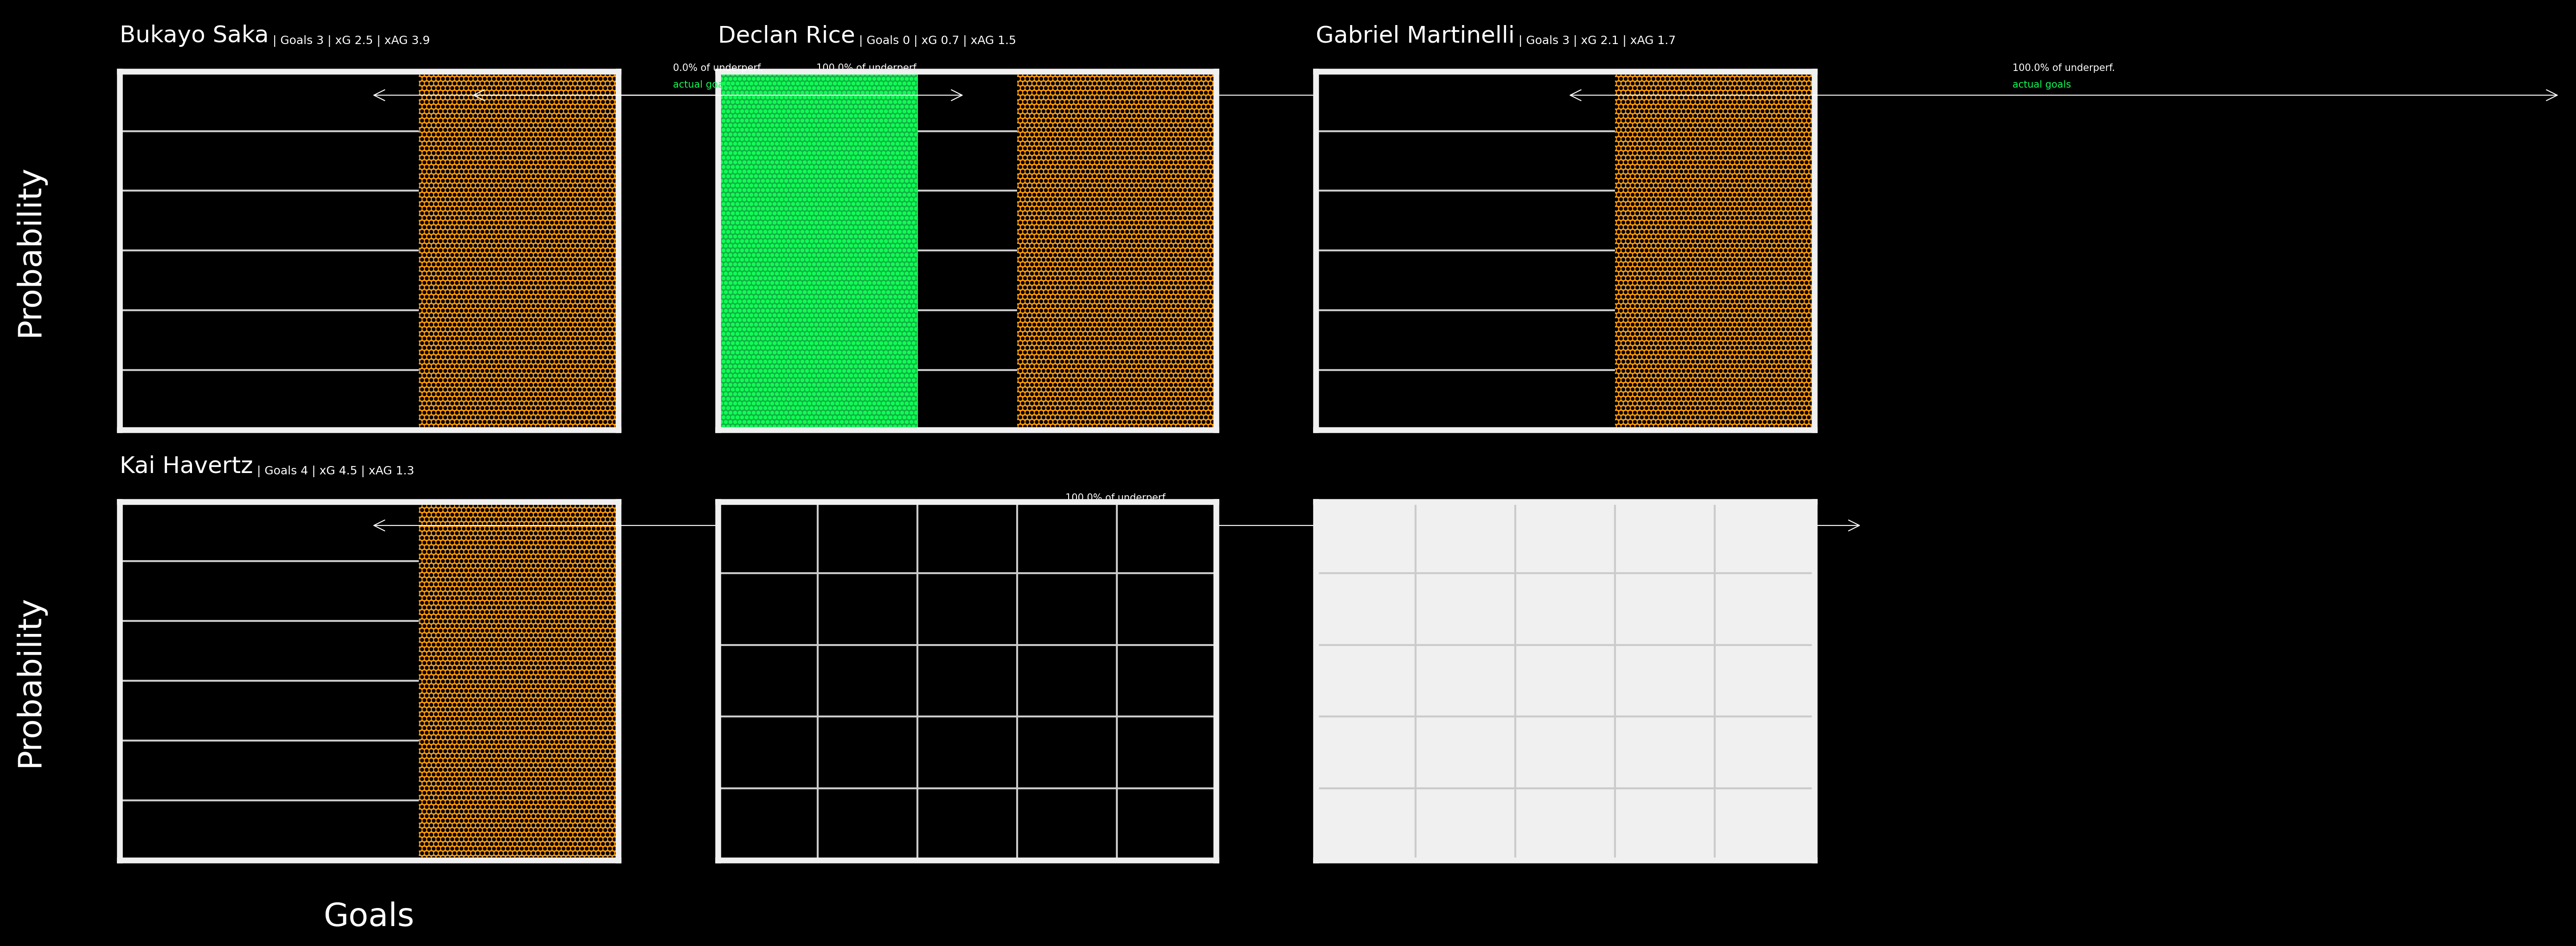

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7), dpi=300, facecolor='#000000')
axs = np.array(axs)
for index, ax in enumerate(axs.reshape(-1)):
    ax.set_facecolor('#000000')
    if index < 3:
        label_x = False
    else:
        label_x = True
    if index in [0,3]:
        label_y = True
    else:
        label_y = False
    plot_goal_sim(ax, Player=df_top_10['Player'].iloc[index], label_x=label_x, label_y=label_y)

plt.subplots_adjust(wspace=0.15, hspace=.3)
# We add the logos once we've reshaped the figure
fig_text(
    x=0.1,y=1.03,
    s='Are the EPL\'s Top Scorers Getting Lucky?',
    ha='left',
    va='center',
    size='20',
    color='white'  
)
fig_text(
    x=0.1,y=.98,
    s='Simulation of goals scored based on the xG of each player\'s actual shots taken. | Viz by @sonofacorner',
    ha='left',
    va='center',
    size='9',
    color='white'  
)

plt.savefig(
	"figures/10312022_epl_goals.png",
	dpi = 600,
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

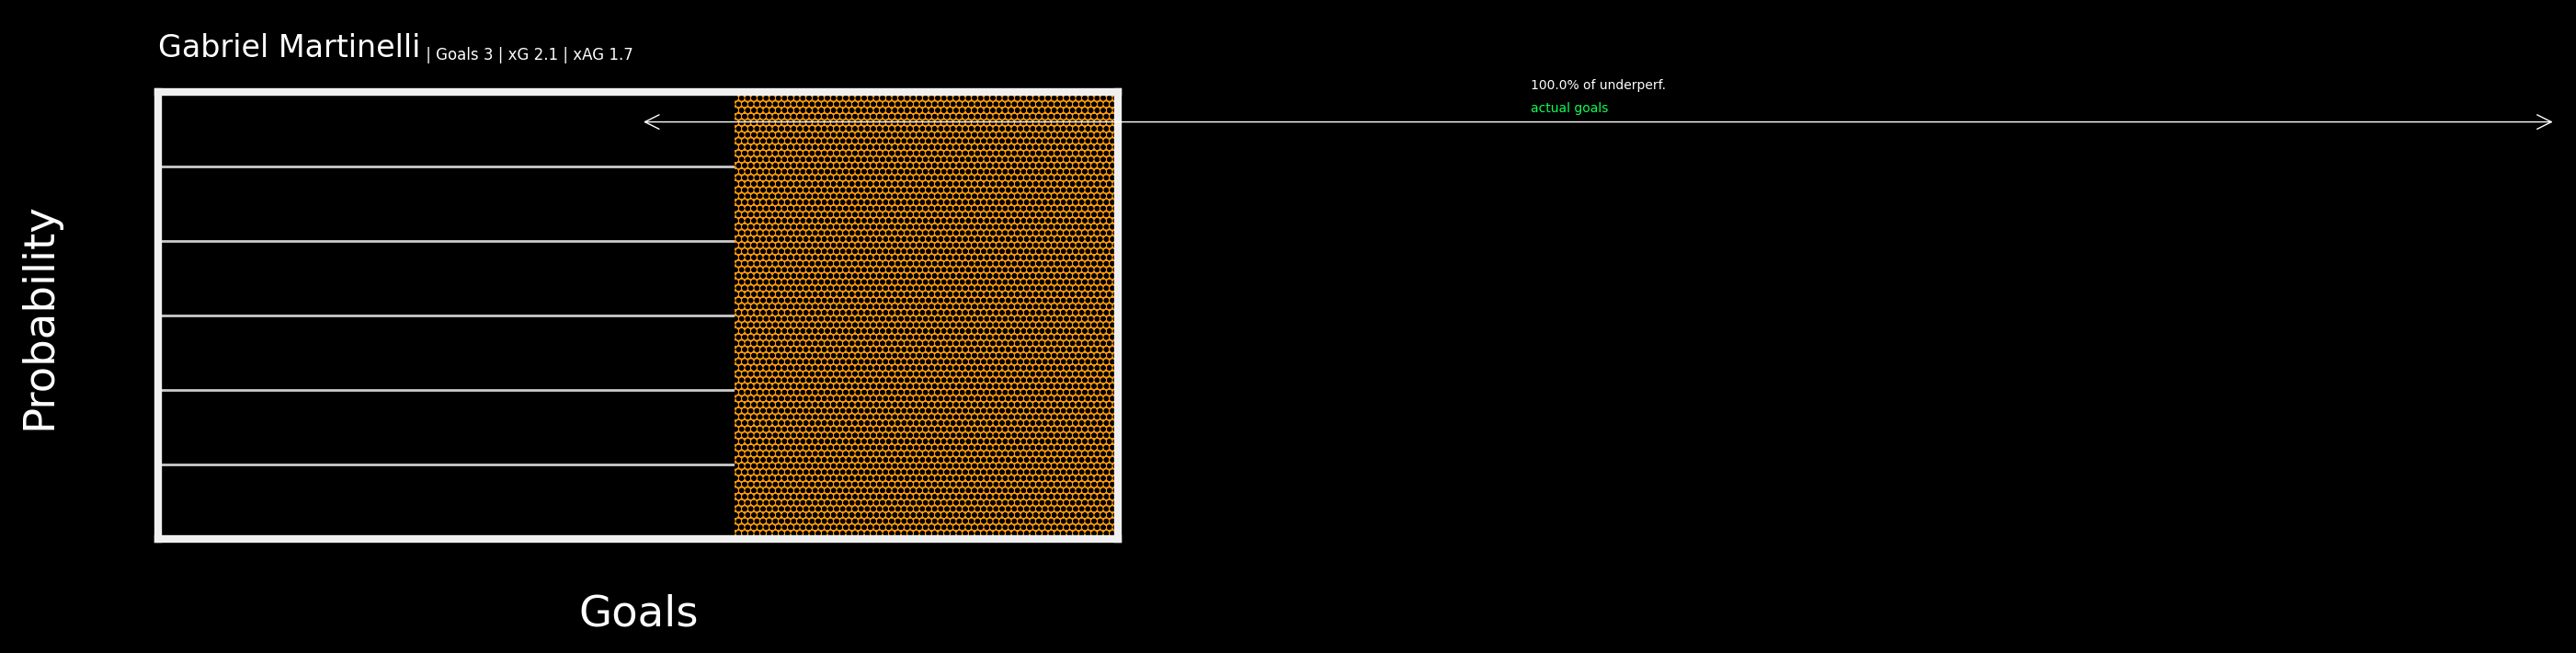

In [92]:
fig = plt.figure(figsize=(6,3), dpi=200, facecolor='#000000')
ax = plt.subplot(facecolor='#000000')

plot_goal_sim(ax, Player='Gabriel Martinelli', label_x=True, label_y=True)